# Perspective Shift Identification

### Goal: 
Use ML to identify perspective shift in movement of distribution centers

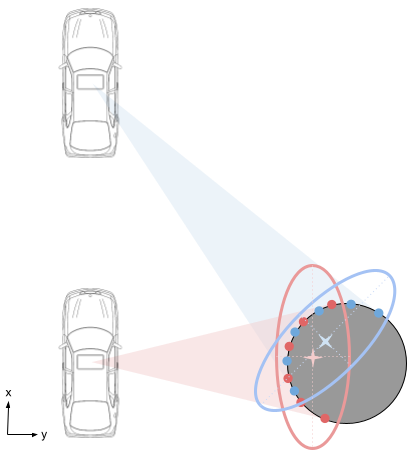

### Assumptions:
Gross rotation and translation have already been estimated by previous scan matching iterations

### Network structure:
Inputs: 
xyz of 25 points randomly sampled from each distribution

Output:
Correction factor translation between the two centers



### Training data generation

(starting with toy example)

1- generate grid of simple shapes in Inventor

2- Rotate randomly, translate randomly and simulate lidar scan of shapes at 2 points in time using MatLab script

3- Sample N points from each object and save to file. Also store information on rotation and translation to seperate file

4- import data here and augment again by duplicating and scaling examples arbitrarily

## TODO

Get tf.data() pipeline working

Scale allowable error threshold between DNN and D2D by radial disatance from origin

NOTE: py39 env needed with new GPU setup
https://www.tensorflow.org/install/source#gpu


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
# import tensorflow_graphics as tfg
# import tensorflow_graphics.nn.layer.pointnet

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

print(tf.__version__) #requires tensorflow 2.3

# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
%matplotlib notebook

%load_ext tensorboard

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.9.1


Autosaving every 180 seconds


In [ ]:
#test pointnet layer...
import tensorflow_graphics as tfg
tfg.nn.layer.pointnet #works in TF2.9 (with CUDNN 8.x)

In [2]:
#define functions to convert between spherical and cartesian coordinate representations
def c2s(pts):
    """ converts points from cartesian coordinates to spherical coordinates """
    r = tf.sqrt(pts[:,0]**2 + pts[:,1]**2 + pts[:,2]**2)
    phi = tf.math.acos(pts[:,2]/r)
    theta = tf.math.atan2(pts[:,1], pts[:,0])

    out = tf.transpose(tf.Variable([r, theta, phi]))
    return(out)
def s2c(pts):
    """converts spherical -> cartesian"""

    x = pts[:,:,0]*tf.math.sin(pts[:,:,2])*tf.math.cos(pts[:,:,1])
    y = pts[:,:,0]*tf.math.sin(pts[:,:,2])*tf.math.sin(pts[:,:,1]) 
    z = pts[:,:,0]*tf.math.cos(pts[:,:,2])

    out = tf.transpose(tf.Variable([x, y, z]))
    # out = tf.Variable([x, y, z])
    return(out)

In [11]:
# old way - non-reduced dimension solution, only feed DNN each point cloud
#_________________________________________________________________
#load individual data numpy files
# d1_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1_scan1.npy")
# d2_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1_scan2.npy")
# gt_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1_ground_truth.npy")

# print(np.shape(d1_1))

# d1_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan1.npy")
# d2_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan2.npy")
# gt_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_ground_truth.npy")

# d1_3 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v3_scan1.npy")
# d2_3 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v3_scan2.npy")
# gt_3 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v3_ground_truth.npy")

d1_4 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v4_scan1.npy")
d2_4 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v4_scan2.npy")
gt_4 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v4_ground_truth.npy")

d1_1 = np.load("C:/Users/Derm/Desktop/big/pshift/scan1_300k_50_samples.npy")
d2_1 = np.load("C:/Users/Derm/Desktop/big/pshift/scan2_300k_50_samples.npy")
gt_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ground_truth_300k_50_samples.npy")
gt_1 = gt_1*0.1 #scale to match real-world data (vel-> pos)

d1 = np.append(d1_1, d1_4, axis = 0)
d2 = np.append(d2_1, d2_4, axis = 0)
gt = np.append(gt_1, gt_4, axis = 0)

# d1 = np.append(d1, d1_3, axis = 0)
# d2 = np.append(d2, d2_3, axis = 0)
# gt = np.append(gt, gt_3, axis = 0)

# d1 = np.append(d1, d1_2, axis = 0)
# d2 = np.append(d2, d2_2, axis = 0)
# gt = np.append(gt, gt_2, axis = 0)
#_________________________________________________________________

#small
# d1 = np.loadtxt("training_data/ICET_Ford_scan1.txt")
# d2 = np.loadtxt("training_data/ICET_Ford_scan2.txt")
# gt = np.loadtxt("training_data/ICET_Ford_ground_truth.txt")

#big
# d1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan1.npy")
# d2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan2.npy")
# gt = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_ground_truth.npy")

# d1 = np.load("C:/Users/Derm/Desktop/big/pshift/scan1_300k_50_samples.npy")
# d2 = np.load("C:/Users/Derm/Desktop/big/pshift/scan2_300k_50_samples.npy")
# gt = np.load("C:/Users/Derm/Desktop/big/pshift/ground_truth_300k_50_samples.npy")
# gt = gt*0.1 #scale to match real-world data (vel-> pos)

#reshape but don't convert to tensor
points_per_sample = 50          #poitns sammpled from each voxel
tsplit = 0.9 #0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)
print(np.shape(x_train))
# print(np.shape(x_test))

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]


(1113347, 100, 3)


In [ ]:
a = np.zeros([10,3])
# b = np.concatenate(a, (a, a), axis = 0)
print(b)
print(np.shape(b))

In [ ]:
#Testing new network structure informed by voxel boundaries
#   input both point clouds AND VOXEL BOUNDS to DNN
#_________________________________________________________________
# big
d1 = np.load("C:/Users/Derm/Desktop/big/pshift/compact_scan1.npy")
d2 = np.load("C:/Users/Derm/Desktop/big/pshift/compact_scan2.npy")
gt = np.load("C:/Users/Derm/Desktop/big/pshift/compact_ground_truth.npy")
LUT = np.load("C:/Users/Derm/Desktop/big/pshift/LUT.npy")
L = np.load("C:/Users/Derm/Desktop/big/pshift/L.npy")
U = np.load("C:/Users/Derm/Desktop/big/pshift/U.npy")
corn = np.load("C:/Users/Derm/Desktop/big/pshift/corn.npy")

#small
# d1 = np.load('training_data/compact_scan1.npy')
# d2 = np.load('training_data/compact_scan2.npy')
# gt = np.load('training_data/compact_ground_truth.npy')
# LUT = np.load('training_data/LUT.npy') 
# L = np.load('training_data/L.npy')
# U = np.load('training_data/U.npy')
# corn = np.load('training_data/corn.npy')
#_________________________________________________________________

#loop through each element of corn and convert from spherical to cartesian
# print(np.shape(corn))
new_corn = np.transpose(s2c(corn), [1,0,2,])
# print(np.shape(new_corn))

#reshape but don't convert to tensor
points_per_sample = 50          #poitns sammpled from each voxel
tsplit = 0.9 #0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)

#combine voxel bound to each training example
x_train = np.append(x_train, new_corn[:ntrain], axis = 1)
x_test = np.append(x_test, new_corn[ntrain:], axis = 1)

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]
# y_train = gt[:ntrain][:,:,0] #when using compact data
# y_test = gt[ntrain:][:,:,0]
LUT = tf.convert_to_tensor(LUT)[ntrain:]
U = tf.convert_to_tensor(U)[ntrain:]
L = tf.convert_to_tensor(L)[ntrain:]
corn_train = corn[:ntrain]
corn_test = corn[ntrain:]

print(np.shape(x_train))
# print(np.shape(x_test))

In [12]:
#train network
from network import Net
# from network import TestNet as Net
# from network import PointNet as Net
# from network import Attention as Net

runLen = 300

def scheduler(epoch, learning_rate):
#     part1 = 2*runLen//3
#     part2 = 5*runLen//6 #net1

    part1 = runLen//3
    part2 = 2*runLen//3 #net2

    if epoch < part1:
        learning_rate = 0.002
        return learning_rate
    if epoch >= part1 and epoch < part2:
        learning_rate = 0.001
        return learning_rate
    if epoch >= part2:
        learning_rate = 0.00025
        return learning_rate

model = Net() #comment out to re-train existing network
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.MeanAbsoluteError()) #was MeanSquaredError()

summary = model.summary()
print(summary)
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
cp = tf.keras.callbacks.ModelCheckpoint("FordNetCP.kmod", monitor = 'val_loss', save_best_only = True) 

log_dir = "runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

trace = model.fit(x = x_train, y = y_train, batch_size = 2048, epochs=runLen, verbose=1, 
                  validation_split = 0.2, shuffle=True, callbacks = [cp])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 tf.expand_dims_2 (TFOpLambd  (None, 100, 3, 1)        0         
 a)                                                              
                                                                 
 conv2d (Conv2D)             (None, 100, 1, 64)        256       
                                                                 
 batch_normalization_8 (Batc  (None, 100, 1, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 1, 64)        4160      
                                                                 
 batch_normalization_9 (Batc  (None, 100, 1, 64)       256 

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 54s 121ms/step - loss: 0.2772 - val_loss: 0.1364
Epoch 2/300
435/435 [==============================] - ETA: 0s - loss: 0.1389

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 51s 116ms/step - loss: 0.1389 - val_loss: 0.1110
Epoch 3/300
435/435 [==============================] - 47s 107ms/step - loss: 0.1167 - val_loss: 0.1198
Epoch 4/300
435/435 [==============================] - ETA: 0s - loss: 0.1050

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 52s 120ms/step - loss: 0.1050 - val_loss: 0.0868
Epoch 5/300
435/435 [==============================] - ETA: 0s - loss: 0.0988

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 51s 118ms/step - loss: 0.0988 - val_loss: 0.0850
Epoch 6/300
435/435 [==============================] - 52s 119ms/step - loss: 0.0935 - val_loss: 0.0956
Epoch 7/300
435/435 [==============================] - ETA: 0s - loss: 0.0887

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 46s 106ms/step - loss: 0.0887 - val_loss: 0.0737
Epoch 8/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0847 - val_loss: 0.0783
Epoch 9/300
435/435 [==============================] - ETA: 0s - loss: 0.0809

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 43s 100ms/step - loss: 0.0809 - val_loss: 0.0689
Epoch 10/300
435/435 [==============================] - 46s 106ms/step - loss: 0.0782 - val_loss: 0.0847
Epoch 11/300
435/435 [==============================] - 43s 98ms/step - loss: 0.0755 - val_loss: 0.0721
Epoch 12/300
435/435 [==============================] - 46s 105ms/step - loss: 0.0746 - val_loss: 0.0886
Epoch 13/300
435/435 [==============================] - ETA: 0s - loss: 0.0736

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 44s 101ms/step - loss: 0.0736 - val_loss: 0.0662
Epoch 14/300
435/435 [==============================] - ETA: 0s - loss: 0.0712

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 45s 103ms/step - loss: 0.0712 - val_loss: 0.0649
Epoch 15/300
435/435 [==============================] - ETA: 0s - loss: 0.0703

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 45s 104ms/step - loss: 0.0703 - val_loss: 0.0596
Epoch 16/300
435/435 [==============================] - ETA: 0s - loss: 0.0686

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 45s 104ms/step - loss: 0.0686 - val_loss: 0.0559
Epoch 17/300
435/435 [==============================] - 43s 98ms/step - loss: 0.0677 - val_loss: 0.0961
Epoch 18/300
435/435 [==============================] - 43s 100ms/step - loss: 0.0668 - val_loss: 0.0639
Epoch 19/300
435/435 [==============================] - 45s 103ms/step - loss: 0.0689 - val_loss: 0.0598
Epoch 20/300
435/435 [==============================] - 46s 107ms/step - loss: 0.0653 - val_loss: 0.0576
Epoch 21/300
435/435 [==============================] - 49s 113ms/step - loss: 0.0644 - val_loss: 0.0641
Epoch 22/300
435/435 [==============================] - ETA: 0s - loss: 0.0649

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 45s 103ms/step - loss: 0.0649 - val_loss: 0.0485
Epoch 23/300
435/435 [==============================] - 46s 105ms/step - loss: 0.0643 - val_loss: 0.0490
Epoch 24/300
435/435 [==============================] - 45s 104ms/step - loss: 0.0625 - val_loss: 0.0544
Epoch 25/300
435/435 [==============================] - 43s 98ms/step - loss: 0.0626 - val_loss: 0.0632
Epoch 26/300
435/435 [==============================] - 43s 100ms/step - loss: 0.0611 - val_loss: 0.0511
Epoch 27/300
435/435 [==============================] - ETA: 0s - loss: 0.0600

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 45s 104ms/step - loss: 0.0600 - val_loss: 0.0480
Epoch 28/300
435/435 [==============================] - ETA: 0s - loss: 0.0612

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 44s 100ms/step - loss: 0.0612 - val_loss: 0.0480
Epoch 29/300
435/435 [==============================] - 44s 101ms/step - loss: 0.0588 - val_loss: 0.0504
Epoch 30/300
435/435 [==============================] - 43s 99ms/step - loss: 0.0603 - val_loss: 0.0485
Epoch 31/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0588 - val_loss: 0.0563
Epoch 32/300
435/435 [==============================] - 45s 103ms/step - loss: 0.0589 - val_loss: 0.0606
Epoch 33/300
435/435 [==============================] - 44s 102ms/step - loss: 0.0585 - val_loss: 0.0506
Epoch 34/300
435/435 [==============================] - 43s 99ms/step - loss: 0.0574 - val_loss: 0.0603
Epoch 35/300
435/435 [==============================] - 44s 101ms/step - loss: 0.0569 - val_loss: 0.0527
Epoch 36/300
435/435 [==============================] - ETA: 0s - loss: 0.0561

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 46s 107ms/step - loss: 0.0561 - val_loss: 0.0438
Epoch 37/300
435/435 [==============================] - ETA: 0s - loss: 0.0602

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 45s 102ms/step - loss: 0.0602 - val_loss: 0.0424
Epoch 38/300
435/435 [==============================] - 43s 100ms/step - loss: 0.0572 - val_loss: 0.0486
Epoch 39/300
435/435 [==============================] - 44s 100ms/step - loss: 0.0564 - val_loss: 0.0555
Epoch 40/300
435/435 [==============================] - 43s 99ms/step - loss: 0.0566 - val_loss: 0.0891
Epoch 41/300
435/435 [==============================] - ETA: 0s - loss: 0.0559

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 45s 104ms/step - loss: 0.0559 - val_loss: 0.0395
Epoch 42/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0559 - val_loss: 0.0456
Epoch 43/300
435/435 [==============================] - 45s 104ms/step - loss: 0.0546 - val_loss: 0.0415
Epoch 44/300
435/435 [==============================] - ETA: 0s - loss: 0.0542

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 46s 106ms/step - loss: 0.0542 - val_loss: 0.0370
Epoch 45/300
435/435 [==============================] - 52s 120ms/step - loss: 0.0541 - val_loss: 0.0424
Epoch 46/300
435/435 [==============================] - 43s 99ms/step - loss: 0.0549 - val_loss: 0.0420
Epoch 47/300
435/435 [==============================] - 43s 100ms/step - loss: 0.0538 - val_loss: 0.0389
Epoch 48/300
435/435 [==============================] - 43s 99ms/step - loss: 0.0536 - val_loss: 0.0412
Epoch 49/300
435/435 [==============================] - 44s 100ms/step - loss: 0.0530 - val_loss: 0.0448
Epoch 50/300
435/435 [==============================] - 42s 98ms/step - loss: 0.0531 - val_loss: 0.0479
Epoch 51/300
435/435 [==============================] - 42s 97ms/step - loss: 0.0528 - val_loss: 0.0374
Epoch 52/300
435/435 [==============================] - 42s 97ms/step - loss: 0.0527 - val_loss: 0.0453
Epoch 53/300
435/435 [==============================] - 42s 97ms/step - l

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 43s 100ms/step - loss: 0.0512 - val_loss: 0.0348
Epoch 62/300
435/435 [==============================] - 42s 95ms/step - loss: 0.0514 - val_loss: 0.0455
Epoch 63/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0525 - val_loss: 0.0487
Epoch 64/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0525 - val_loss: 0.0442
Epoch 65/300
435/435 [==============================] - 42s 97ms/step - loss: 0.0512 - val_loss: 0.0710
Epoch 66/300
435/435 [==============================] - ETA: 0s - loss: 0.0527

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 45s 103ms/step - loss: 0.0527 - val_loss: 0.0346
Epoch 67/300
435/435 [==============================] - 42s 97ms/step - loss: 0.0530 - val_loss: 0.0383
Epoch 68/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0522 - val_loss: 0.0354
Epoch 69/300
435/435 [==============================] - 42s 97ms/step - loss: 0.0513 - val_loss: 0.0397
Epoch 70/300
435/435 [==============================] - 42s 97ms/step - loss: 0.0504 - val_loss: 0.0420
Epoch 71/300
435/435 [==============================] - 42s 97ms/step - loss: 0.0509 - val_loss: 0.0396
Epoch 72/300
435/435 [==============================] - 42s 97ms/step - loss: 0.0505 - val_loss: 0.0393
Epoch 73/300
435/435 [==============================] - ETA: 0s - loss: 0.0500

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 44s 102ms/step - loss: 0.0500 - val_loss: 0.0321
Epoch 74/300
435/435 [==============================] - 42s 97ms/step - loss: 0.0508 - val_loss: 0.0366
Epoch 75/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0504 - val_loss: 0.0356
Epoch 76/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0507 - val_loss: 0.0572
Epoch 77/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0525 - val_loss: 0.0412
Epoch 78/300
435/435 [==============================] - 43s 99ms/step - loss: 0.0506 - val_loss: 0.0427
Epoch 79/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0501 - val_loss: 0.0360
Epoch 80/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0513 - val_loss: 0.0430
Epoch 81/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0508 - val_loss: 0.0370
Epoch 82/300
435/435 [==============================] - 42s 96ms/step - loss

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 43s 100ms/step - loss: 0.0474 - val_loss: 0.0312
Epoch 107/300
435/435 [==============================] - 42s 95ms/step - loss: 0.0473 - val_loss: 0.0343
Epoch 108/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0468 - val_loss: 0.0387
Epoch 109/300
435/435 [==============================] - 42s 95ms/step - loss: 0.0471 - val_loss: 0.0341
Epoch 110/300
435/435 [==============================] - 41s 95ms/step - loss: 0.0469 - val_loss: 0.0330
Epoch 111/300
435/435 [==============================] - ETA: 0s - loss: 0.0468

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 44s 100ms/step - loss: 0.0468 - val_loss: 0.0304
Epoch 112/300
435/435 [==============================] - 42s 95ms/step - loss: 0.0478 - val_loss: 0.0404
Epoch 113/300
435/435 [==============================] - 41s 95ms/step - loss: 0.0497 - val_loss: 0.0361
Epoch 114/300
435/435 [==============================] - 41s 95ms/step - loss: 0.0480 - val_loss: 0.0423
Epoch 115/300
435/435 [==============================] - 41s 95ms/step - loss: 0.0508 - val_loss: 0.0428
Epoch 116/300
435/435 [==============================] - 42s 95ms/step - loss: 0.0490 - val_loss: 0.0341
Epoch 117/300
435/435 [==============================] - 41s 95ms/step - loss: 0.0472 - val_loss: 0.0341
Epoch 118/300
435/435 [==============================] - 41s 95ms/step - loss: 0.0468 - val_loss: 0.0321
Epoch 119/300
435/435 [==============================] - 41s 95ms/step - loss: 0.0467 - val_loss: 0.0343
Epoch 120/300
435/435 [==============================] - 41s 95ms/st

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 43s 100ms/step - loss: 0.0463 - val_loss: 0.0303
Epoch 136/300
435/435 [==============================] - ETA: 0s - loss: 0.0460

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 44s 100ms/step - loss: 0.0460 - val_loss: 0.0296
Epoch 137/300
435/435 [==============================] - 42s 95ms/step - loss: 0.0473 - val_loss: 0.0875
Epoch 138/300
435/435 [==============================] - 41s 95ms/step - loss: 0.0494 - val_loss: 0.0386
Epoch 139/300
435/435 [==============================] - 41s 95ms/step - loss: 0.0465 - val_loss: 0.0330
Epoch 140/300
435/435 [==============================] - 41s 95ms/step - loss: 0.0463 - val_loss: 0.0310
Epoch 141/300
435/435 [==============================] - 44s 100ms/step - loss: 0.0485 - val_loss: 0.0836
Epoch 142/300
435/435 [==============================] - 44s 100ms/step - loss: 0.0491 - val_loss: 0.0333
Epoch 143/300
435/435 [==============================] - 44s 102ms/step - loss: 0.0472 - val_loss: 0.0350
Epoch 144/300
435/435 [==============================] - 42s 97ms/step - loss: 0.0459 - val_loss: 0.0328
Epoch 145/300
435/435 [==============================] - 42s 96ms

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 45s 104ms/step - loss: 0.0439 - val_loss: 0.0287
Epoch 166/300
435/435 [==============================] - 44s 100ms/step - loss: 0.0446 - val_loss: 0.0322
Epoch 167/300
435/435 [==============================] - 42s 98ms/step - loss: 0.0438 - val_loss: 0.0322
Epoch 168/300
435/435 [==============================] - 43s 98ms/step - loss: 0.0446 - val_loss: 0.0303
Epoch 169/300
435/435 [==============================] - 43s 100ms/step - loss: 0.0437 - val_loss: 0.0296
Epoch 170/300
435/435 [==============================] - 46s 105ms/step - loss: 0.0437 - val_loss: 0.0322
Epoch 171/300
435/435 [==============================] - 45s 104ms/step - loss: 0.0479 - val_loss: 0.0358
Epoch 172/300
435/435 [==============================] - 44s 101ms/step - loss: 0.0465 - val_loss: 0.0292
Epoch 173/300
435/435 [==============================] - 43s 99ms/step - loss: 0.0453 - val_loss: 0.0358
Epoch 174/300
435/435 [==============================] - 46s 10

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 45s 103ms/step - loss: 0.0432 - val_loss: 0.0287
Epoch 187/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0430 - val_loss: 0.0302
Epoch 188/300
435/435 [==============================] - 42s 98ms/step - loss: 0.0426 - val_loss: 0.0289
Epoch 189/300
435/435 [==============================] - ETA: 0s - loss: 0.0428

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 46s 105ms/step - loss: 0.0428 - val_loss: 0.0281
Epoch 190/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0429 - val_loss: 0.0364
Epoch 191/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0458 - val_loss: 0.0429
Epoch 192/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0443 - val_loss: 0.0315
Epoch 193/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0432 - val_loss: 0.0306
Epoch 194/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0428 - val_loss: 0.0288
Epoch 195/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0433 - val_loss: 0.0304
Epoch 196/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0427 - val_loss: 0.0310
Epoch 197/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0429 - val_loss: 0.0311
Epoch 198/300
435/435 [==============================] - 42s 96ms/st

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 46s 106ms/step - loss: 0.0423 - val_loss: 0.0279
Epoch 204/300
435/435 [==============================] - 45s 103ms/step - loss: 0.0419 - val_loss: 0.0312
Epoch 205/300
435/435 [==============================] - 45s 102ms/step - loss: 0.0422 - val_loss: 0.0377
Epoch 206/300
435/435 [==============================] - 45s 104ms/step - loss: 0.0425 - val_loss: 0.0295
Epoch 207/300
435/435 [==============================] - 47s 107ms/step - loss: 0.0428 - val_loss: 0.0303
Epoch 208/300
435/435 [==============================] - 43s 100ms/step - loss: 0.0421 - val_loss: 0.0481
Epoch 209/300
435/435 [==============================] - 42s 97ms/step - loss: 0.0427 - val_loss: 0.0286
Epoch 210/300
435/435 [==============================] - ETA: 0s - loss: 0.0421

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 44s 101ms/step - loss: 0.0421 - val_loss: 0.0271
Epoch 211/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0419 - val_loss: 0.0296
Epoch 212/300
435/435 [==============================] - 42s 97ms/step - loss: 0.0420 - val_loss: 0.0297
Epoch 213/300
435/435 [==============================] - 43s 99ms/step - loss: 0.0417 - val_loss: 0.0313
Epoch 214/300
435/435 [==============================] - 43s 98ms/step - loss: 0.0418 - val_loss: 0.0279
Epoch 215/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0419 - val_loss: 0.0312
Epoch 216/300
435/435 [==============================] - 43s 99ms/step - loss: 0.0417 - val_loss: 0.0279
Epoch 217/300
435/435 [==============================] - 43s 98ms/step - loss: 0.0416 - val_loss: 0.0291
Epoch 218/300
435/435 [==============================] - 42s 97ms/step - loss: 0.0450 - val_loss: 0.0478
Epoch 219/300
435/435 [==============================] - 43s 99ms/st

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


435/435 [==============================] - 45s 104ms/step - loss: 0.0397 - val_loss: 0.0265
Epoch 284/300
435/435 [==============================] - 43s 98ms/step - loss: 0.0397 - val_loss: 0.0298
Epoch 285/300
435/435 [==============================] - 42s 96ms/step - loss: 0.0401 - val_loss: 0.0292
Epoch 286/300
435/435 [==============================] - 43s 99ms/step - loss: 0.0398 - val_loss: 0.0298
Epoch 287/300
435/435 [==============================] - 49s 113ms/step - loss: 0.0398 - val_loss: 0.0292
Epoch 288/300
435/435 [==============================] - 52s 120ms/step - loss: 0.0395 - val_loss: 0.0280
Epoch 289/300
435/435 [==============================] - 53s 122ms/step - loss: 0.0413 - val_loss: 0.0426
Epoch 290/300
435/435 [==============================] - 53s 121ms/step - loss: 0.0418 - val_loss: 0.0289
Epoch 291/300
435/435 [==============================] - 52s 119ms/step - loss: 0.0403 - val_loss: 0.0302
Epoch 292/300
435/435 [==============================] - 51s 11

### Top Scores
#### C:/Users/Derm/Desktop/big/pshift/scan1_10k_50_samples.txt 
 no rotation in objects used to train DNN 

-- 0.69 MAE using the CNN kernel hack presented in PCR-Net

-- 0.60 MAE using my strategy

-- 0.36 MAE using simplified PCR-Net

#### C:/Users/Derm/Desktop/big/pshift/scan1_1k_50_samples.txt 

-- 0.56 MAE, bs=32

#### C:/Users/Derm/Desktop/big/pshift/scan1_300k_50_samples.txt 

-- 0.39 MAE, bs = 64, epoch = 99 (saved as <Net.kmod>)

#### C:/Users/Derm/Desktop/big/pshift/ICET_Ford.txt

-- 0.047 MAE, bs = 256, epoch = 300

#### C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2.txt
(100 shifts from 10 frames)

-- 0.030 MAE, bs = 512, epoch = 300

#### C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1+2.txt
--0.032 MAE, bs = 1024, with cnn, epoch = 100

#### Ford2 + 300k synthetic

-- 0.06 MAE with NET, ?? epoch

-- 0.078 MAE MaxPool1D -> Attention, 30 epoch

### v1+v4
0.04 MAE, bs = 512, w/ 256 Conv and 256 FF, epoch = 30

0.033 MAE, bs = 1024, 64 conv 64 FF, epoch = 100

0.027 MAE, bs = 1024, 64 conv, 64 FF, epoch = 300 [FordNetV3]

<IPython.core.display.Javascript object>


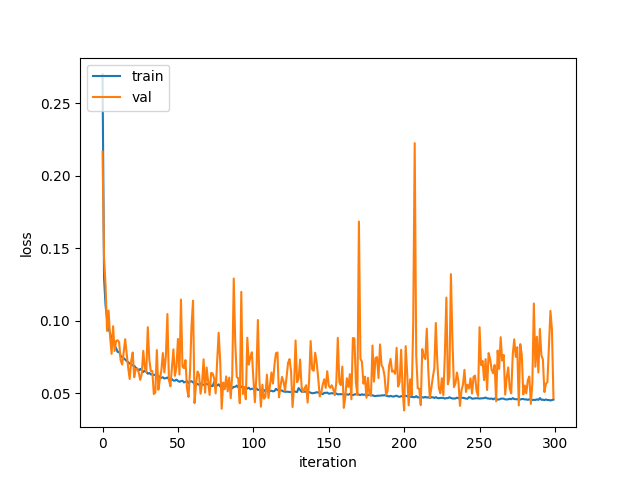

Text(0, 0.5, 'loss')

In [6]:
fig0, ax0 = plt.subplots()
ax0.plot(trace.history['loss'], '-')
ax0.plot(trace.history['val_loss'], '-')
ax0.legend(['train', 'val'], loc='upper left')
ax0.set_xlabel('iteration')
ax0.set_ylabel('loss')

In [7]:
# estimates = model.predict(x_train[0:100:16])
# print(estimates)
# print(y_train[0:100:16])
estimates = model.predict(x_test[:10]) #* 10
print("estimated translation x y z")
print(estimates)
print("actual translation x y z")
print(y_test[:10])

err = y_test[:10] - estimates
# err = y_train[0:100:16] - estimates

print("\n Error \n",err)

print(tf.math.reduce_mean(tf.math.reduce_sum(err, axis = 1)))




1/1 [==============================] - 0s 499ms/step
estimated translation x y z
[[-0.57496315  0.51908183 -0.0766843 ]
 [ 0.21017364 -0.09628896 -0.03129356]
 [-2.2766523   1.5417862   0.07692916]
 [ 0.6136902   1.9474214   0.02701784]
 [ 1.721188    1.3511986  -0.04287718]
 [-2.675208    0.7594997   0.12785569]
 [-0.5868614   0.08614849 -0.12958615]
 [-0.7991657  -0.90208125 -0.09809152]
 [-0.51842564  0.79771215 -0.16804501]
 [ 0.09116109  0.2264352   0.1546298 ]]
actual translation x y z
[[-0.53767616  0.43226847 -0.10343488]
 [ 0.24854778 -0.1771922  -0.04946589]
 [-2.2236557   1.46474469  0.06424494]
 [ 0.65221065  1.89100528  0.0081946 ]
 [ 1.72991061  1.28372049 -0.05821136]
 [-2.69916677  0.67205811  0.11757749]
 [-0.57233495 -0.02096893 -0.1296562 ]
 [-0.76790684 -0.98293072 -0.12999502]
 [-0.49831334  0.71898925 -0.19698909]
 [ 0.12633248  0.1541342   0.1369599 ]]

 Error 
 [[ 3.72869968e-02 -8.68133605e-02 -2.67505795e-02]
 [ 3.83741409e-02 -8.09032395e-02 -1.81723274e-02]


<IPython.core.display.Javascript object>


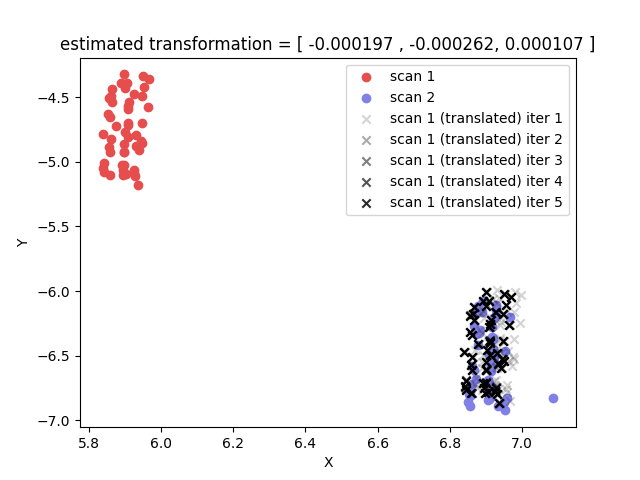

n =  27
1/1 [==============================] - 0s 11ms/step

 correct soln [ 1.00858402 -1.79070878 -0.15881842]

 estiamted soln: [[ 1.00121972 -1.68571104 -0.13619684]]

 error from DNN: [[ 0.0073643  -0.10499774 -0.02262159]]

 error in means [ 0.00233812 -0.01180609 -0.03364728]


In [8]:
#visualize results of network on test data
#2d plots (x and y only)
fig1, ax1 = plt.subplots()
n = int(np.floor(100*np.random.rand()))
# n = 8 #sample number (from x_test)

print("n = ", n)

# print(tf.shape(x_test))
# c1 = np.array([x_test[n,:points_per_sample,0].numpy(), x_test[n,:points_per_sample,1].numpy(), x_test[n,:points_per_sample,2].numpy()])
# c2 = np.array([x_test[n,points_per_sample:,0].numpy(), x_test[n,points_per_sample:,1].numpy(), x_test[n,points_per_sample:,2].numpy()])
c1 = np.array([x_test[n,:points_per_sample,0], x_test[n,:points_per_sample,1], x_test[n,:points_per_sample,2]])
c2 = np.array([x_test[n,points_per_sample:(points_per_sample*2),0], x_test[n,points_per_sample:(points_per_sample*2),1], x_test[n,points_per_sample:(points_per_sample*2),2]])
ax1.scatter(c1[0,:], c1[1,:], color = [0.9, 0.3, 0.3], label = 'scan 1')
ax1.scatter(c2[0,:], c2[1,:], color = [0.5, 0.5, 0.9], label = 'scan 2')


inputs = x_test[n][None,:]
# print(x_test[n, 100:])
runlen = 5
corr_sum = np.zeros([1,3]) #init var to store correction contributions
for i in range(runlen):
    correction = model.predict(inputs)[0] #show what the network thinks
#     correction = correction*0.1
#     correction = y_test[n] #show actual solution
    corr_sum += correction
#     print(correction)
    c1 = np.array([c1[0,:] + correction[0], c1[1,:] + correction[1], c1[2,:] + correction[2]])
    inputs = np.append(c1, c2, axis = 1).T[None,:,:]
#     print(tf.shape(inputs))
#     print(tf.shape(x_test[n,None,100:]))
    inputs = np.append(inputs, x_test[n,None,100:], axis = 1)
    moved = ax1.scatter(c1[0,:], c1[1,:], marker = 'x', color = [0., 0., 0., (i+1)/(runlen+1)],
                        label = 'scan 1 (translated) iter %i' %(i+1))

# moved = ax1.scatter(c1[0,:], c1[1,:], marker = 'x', color = [0.9, 0.3, 0.3, (i+2)/(runlen+2)],
#                         label = 'scan 1 (translated)')

ax1.set_title("estimated transformation = [ %f , %f, %f ]" %(correction[0], correction[1], correction[2]))
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.legend(loc = 'best')

print("\n correct soln", y_test[n])
# print("\n y_test", y_test[n]*0.1)
print("\n estiamted soln:", corr_sum)
print("\n error from DNN:", y_test[n] - corr_sum)
print("\n error in means",  y_test[n] + (np.mean(x_test[n,:points_per_sample], axis = 0) - 
      np.mean(x_test[n,points_per_sample:], axis = 0)))

In [9]:
#use Vedo to plot inital and transformed point clouds in 3D 
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget

plt1 = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True)
disp = []

#draw scan1 
# disp.append(Points(x_test[n,:points_per_sample].numpy(), c = 'green', r = 5))
disp.append(Points(x_test[n,:points_per_sample], c = 'green', r = 5))

#draw initial scan2
# disp.append(Points(x_test[n,points_per_sample:].numpy(), c = 'red', r = 5))
disp.append(Points(x_test[n,points_per_sample:points_per_sample*2], c = 'red', r = 5))

#draw transformed scan2
disp.append(Points(c1, c = 'blue', r = 5))

plt1.show(disp, "Network Performance Test")
ViewInteractiveWidget(plt1.window)



ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [ ]:
#save network
# model.save("ffnet10k25.kmod")
# model.save("Net.kmod")
# model.save("PIPEnet10.kmod")
# model.save("KITTInet.kmod")
# model.save("FordNet.kmod")
# model.save("FordNetV3.kmod")
# model.save("FordNetCP.kmod")

#load network
# model = tf.keras.models.load_model("Net.kmod")
# model = tf.keras.models.load_model("FordNet.kmod")
# model = tf.keras.models.load_model("PIPEnet10.kmod")
# model = tf.keras.models.load_model("KITTInet.kmod")
# model = tf.keras.models.load_model("FORDNetV3.kmod")

In [ ]:
#test random shuffle layer to enforce training on unordered data
#GOAL: randomize order of each sample in batch SEPRATELY 
#      (i.e. don't have same order for all elements of batch)

test = tf.constant([[1., 3., 4.], [2., 3., 5.], [6., 6., 6.], [0., 0., 0.]])#[None, :, :]
test = tf.Variable([test, 2*test])
print(test)

test = tf.transpose(test, [1,0,2])
test = tf.random.shuffle(test)
test = tf.transpose(test, [1,0,2])
print(test)

### Top scores:

#### 1k dataset
8.23 MSE with no parallelization (vel = [5, 5, 5])

4.2 MSE (vel = [5, 5, 0.01])

3.9 MSE - 50 sample points from each scan

3.34- maxpool on first/ second half, conv after


#### 10k dataset

2.4 MSE 50 samples

1.05 MSE 25 samples -ffNet10k25.kmod

### KITTI drive 005, 100 frames

0.145 - Permnet

0.0895 -PCRnet

0.0520 KITTInet (5/20)

### KITTI drive 005, 150 frames, 50 sample points
0.759 pipeNET

### Ford Campus Drive 01 (200 frame sample)
0.073 - NET, 200 frames, with ground plane

### KITTI Full 00 400 frames, with ground plane
0.0752 net

### KITTI Full 00 400 frames, no ground plane
0.0756

### KITTI Full 00 4500 frames, with ground plane
0.0736 net


### Notes
From PointNet: Small rotations and gaussian noise can successfully augment models to increase training dataset

Need to figure out a way to achieve permutation invariance
Try transformer network i.e. "Attention is all you need"
https://ai.googleblog.com/2021/11/permutation-invariant-neural-networks.html

Can potentially use reflectance as 4th dimension(?)

### Find average error in mean point locations when ground truth solution is applied
Test for indexing when geterating training data using Ford dataset - this error should be minimal when we are correctly indexing gt

In [ ]:
d1 = np.loadtxt('training_data/ICET_Ford_scan1.txt') #available in repo
d2 = np.loadtxt('training_data/ICET_Ford_scan2.txt')
truth = np.loadtxt('training_data/ICET_Ford_ground_truth.txt')

points_per_sample = 50 #25 #50  #num pts per scan - defined in MatLab script
s1 = tf.reshape(tf.convert_to_tensor(d1), [-1, points_per_sample, 3])
s2 = tf.reshape(tf.convert_to_tensor(d2), [-1, points_per_sample, 3])
truth = tf.convert_to_tensor(truth)

In [ ]:
print(tf.shape(s1))
mu1 = tf.math.reduce_mean(s1, axis = 1)
mu2 = tf.math.reduce_mean(s2, axis = 1)
# print("\n mu1", mu1)
# print("\n mu2", mu2)
centers_error = mu1 - mu2 + truth 
# print("\n centers_error", centers_error)

#get mean absolute centers error across all voxels
# mace = tf.math.reduce_mean(abs(centers_error), axis = 0) #absolute error
mace = tf.math.reduce_mean(centers_error, axis = 0)
print("\n mace", mace)